Code for examining how HMM performs under different perturbations to population activity. 

Tests recalibration performance in response to mean shifts, PD shifts

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from HMM_matlab import hmmviterbi_vonmises, hmmdecode_vonmises
from hmm_utils import *
from simulation_matlab import *
from simulation_utils import * 
from stabilizer_utils import *

# for a reproducible result
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [5]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning  = generateUnits(n_units = nUnits, SNR = SNR)

calVelocity    = np.random.normal(size = (nTrainingSteps, 2))
calNeural      = calVelocity.dot(initialTuning[:,1:].T)  + initialTuning[:, 0].T;  # FR = <velocity, PD> + baseline
calNeural      = calNeural + np.random.normal(size = calNeural.shape) * 0.3      # add gaussian noise

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


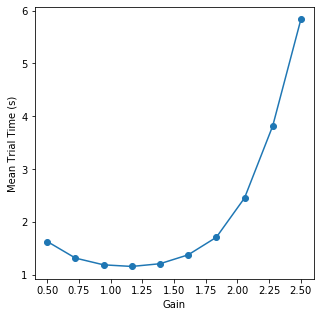

In [6]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [18]:
# general settings:
n_sessions   = 30     # number of sessions to simulate 
days_between = 0      # days between sessions
reps         = 10     # how many times to repeat the repeated nonstationarities simulation
nSimSteps    = 100000 # number of timesteps for simulating session usage 
shrinkage    = 0.92   # relative tuning in subspace per new day

# HMM settings:
vmKappa    = 2          # Precision parameter for the von mises distribution
probThresh = 0.4        # todo: implement
gridSize   = 20
stayProb   = 0.9999


#-----------------------------------------
session_scores          = np.zeros((reps, n_sessions + 1, 3)) # 0: no recalibration, 1: HMM recalibration (just once), 2: repeated HMM recalibration

nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)



for n in range(reps):
    # Day 0 performance:
    ttt                     = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)[-1]
    session_scores[:, 0, :] = np.mean(ttt)
    
    D_HMM  = np.copy(D)
    tuning = np.copy(initialTuning)
    
    for i in range(n_sessions):
        for j in range(days_between + 1):
            tuning = simulateTuningShift(tuning, PD_shrinkage = shrinkage, mean_shift = 0, renormalize = True)  # introduce daily nonstationarities between recorded sessions

        # No recalibration:
        ttt_none               = simulateBCIFitts(tuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] 
        session_scores[n, i+1, 0] = np.mean(ttt_none)


        # HMM recalibration (once):
        cursorPos, _, decOut, _, _, neural, _, ttt_prior = simulateBCIFitts(tuning, D, alpha, beta, nDelaySteps, delT, nSimSteps) 
        targStates, pTargState                           = HMM_estimate([decOut], [cursorPos], stateTrans, pStateStart, targLocs, vmKappa)

        inferredTargLoc  = targLocs[targStates.astype('int').flatten() - 1,:]
        inferredPosErr   = inferredTargLoc - cursorPos

        D_once           = np.linalg.lstsq(np.hstack([np.ones((neural.shape[0], 1)), neural]), inferredPosErr, rcond = -1)[0]  # update previous decoder
        decVec_new       = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_once)

        #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
        #This will restore the original optimal gain.
        inferredTargDist = np.linalg.norm(inferredPosErr, axis = 1)
        inferredTargDir  = inferredPosErr / inferredTargDist[:, np.newaxis]
        farIdx           = np.where(inferredTargDist > 0.4)[0]
        projVec          = np.sum(np.multiply(decVec_new[farIdx, :], inferredTargDir[farIdx, :]), axis = 1)
        D_once          /= np.mean(projVec)

        ttt_Recal               = simulateBCIFitts(tuning, D_once, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
        session_scores[n, i+1, 1]  = np.mean(ttt_Recal)


        # HMM recalibration (repeated):
        cursorPos, _, decOut, _, _, neural, _, ttt_prior = simulateBCIFitts(tuning, D_HMM, alpha, beta, nDelaySteps, delT, nSimSteps) 
        targStates, pTargState                           = HMM_estimate([decOut], [cursorPos], stateTrans, pStateStart, targLocs, vmKappa)

        inferredTargLoc  = targLocs[targStates.astype('int').flatten() - 1,:]
        inferredPosErr   = inferredTargLoc - cursorPos

        D_HMM            = np.linalg.lstsq(np.hstack([np.ones((neural.shape[0], 1)), neural]), inferredPosErr, rcond = -1)[0]  # update previous decoder
        decVec_new       = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_HMM)

        #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
        #This will restore the original optimal gain.
        inferredTargDist = np.linalg.norm(inferredPosErr, axis = 1)
        inferredTargDir  = inferredPosErr / inferredTargDist[:, np.newaxis]
        farIdx           = np.where(inferredTargDist > 0.4)[0]
        projVec          = np.sum(np.multiply(decVec_new[farIdx, :], inferredTargDir[farIdx, :]), axis = 1)
        D_HMM           /= np.mean(projVec)

        ttt_RepeatedRecal          = simulateBCIFitts(tuning, D_HMM, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
        session_scores[n, i+1, 2]  = np.mean(ttt_RepeatedRecal)


C:\Users\ghwilson\Anaconda3\envs\Speech\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ghwilson\Anaconda3\envs\Speech\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Time to target (sec)')

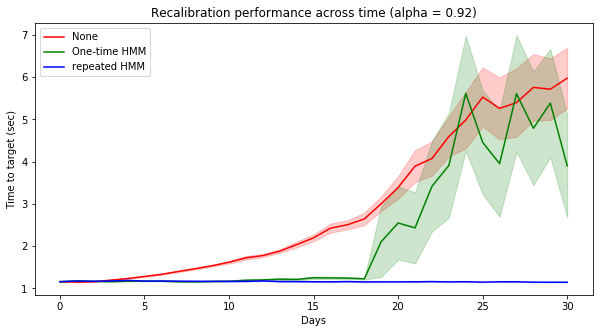

In [40]:
figSize(5, 10)
from lineplots import plotsd

labels = ['None', 'One-time HMM', 'repeated HMM']
colors = ['r', 'g', 'b']
days   = np.linspace(0, (days_between + 1) * n_sessions, n_sessions + 1)

for i, label in enumerate(labels):
    #plt.plot(days, session_scores[9, :, i], label = label)
    plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = True)

plt.legend(labels, loc = 'upper left')
plt.title('Recalibration performance across time (alpha = ' + str(shrinkage) + ')')
plt.xlabel('Days')
plt.ylabel('Time to target (sec)')

In [26]:
session_scores.shape

(10, 31, 3)